In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
import pandas as pd
from sklearn.model_selection import KFold
import numpy as np
import random
import matplotlib.pyplot as plt
from pathlib import Path
import shap
import seaborn as sns

In [2]:
# x = pd.read_csv('/content/train_new.csv')
# y = pd.read_csv('/content/train_new.csv')

In [3]:
x = pd.read_excel('train.xlsx')
y = pd.read_excel('train.xlsx')

In [4]:
X = x.drop(['Class'], axis=1)
Y = y['Class']

In [5]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [9]:
class ParkinsonsANN(nn.Module):
    def __init__(self):
        super(ParkinsonsANN, self).__init__()
        self.fc1 = nn.Linear(26, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.5)


    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        return x

In [10]:
def train_model(X_train_tensor, y_train_tensor, model, criterion, optimizer, epochs=1550):
    for epoch in range(epochs):
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [11]:
model = ParkinsonsANN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0011, weight_decay=1e-5)

In [12]:
train_model(X_train_tensor, y_train_tensor, model, criterion, optimizer)

In [13]:
model = ParkinsonsANN()
model.load_state_dict(torch.load('AIH_ANN_3_weight_decay.pth'))

C:\Users\shree\AppData\Local\Temp\ipykernel_17456\4179537916.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('AIH_ANN_3_weight_decay.pth

<All keys matched successfully>

In [14]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    y_test_pred_class = (y_test_pred >= 0.5).float()

In [15]:
test_accuracy = accuracy_score(y_test, y_test_pred_class.numpy())
print(f'Accuracy on test data: {test_accuracy * 100:.2f}%')

Accuracy on test data: 79.33%


In [16]:
y_test_pred_prob = y_test_pred.numpy()
auc_roc = roc_auc_score(y_test, y_test_pred_prob)
print(f'AUC-ROC Score: {auc_roc:.4f}')

AUC-ROC Score: 0.8963


In [17]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)

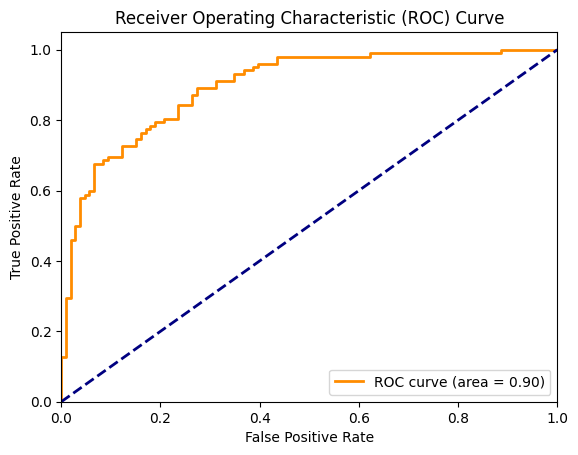

In [18]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [19]:
# MODEL_PATH = Path("model")
# MODEL_PATH.mkdir(parents=True, exist_ok=True)

# MODEL_NAME = "AIH_ANN_3_weight_decay.pth"
# MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# print(f"Saving model to: {MODEL_SAVE_PATH}")
# torch.save(obj=model.state_dict(),
#            f=MODEL_SAVE_PATH)

In [20]:
feature_names = X.columns
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_names)
X_test = pd.DataFrame(scaler.transform(X_test), columns=feature_names)

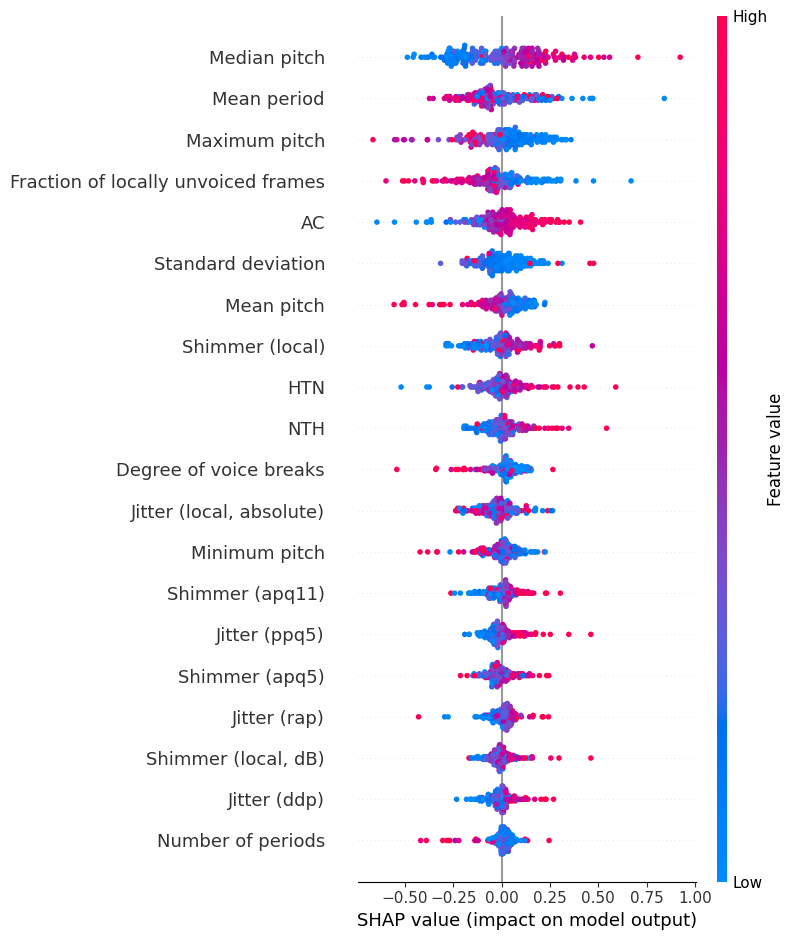

In [21]:
explainer = shap.GradientExplainer(model, X_train_tensor)
shap_values = explainer.shap_values(X_test_tensor)
shap_values = np.squeeze(shap_values)
shap.summary_plot(shap_values,X_test, feature_names=feature_names)

In [22]:
shap_values

array([[-0.0693676 , -0.00932229,  0.01339008, ..., -0.01960272,
        -0.02757242,  0.07398613],
       [-0.00929958, -0.06923607,  0.04193539, ..., -0.12710146,
         0.03558384, -0.1070617 ],
       [-0.1072423 ,  0.26400824, -0.27643633, ...,  0.22473123,
        -0.08658898,  0.08176302],
       ...,
       [-0.01006496, -0.05681584,  0.01157333, ..., -0.02620712,
        -0.00500282, -0.02866966],
       [-0.06470261, -0.04126043, -0.00309384, ..., -0.17720395,
         0.00575888, -0.01945353],
       [-0.02975453, -0.08738118,  0.02940119, ..., -0.40364478,
        -0.0032247 ,  0.1022692 ]])

<Axes: >

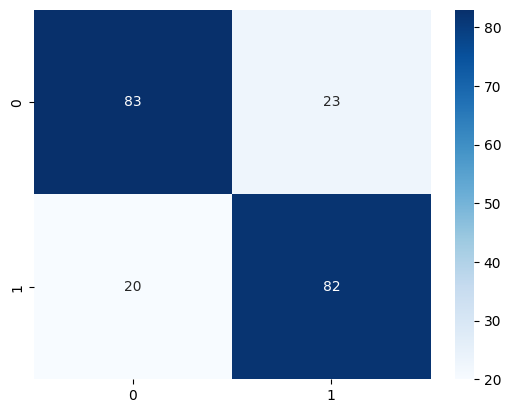

In [27]:
#Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_test_pred_class), annot = True, fmt = 'd', cmap='Blues')

In [30]:
cm = confusion_matrix(y_test, y_test_pred_class)
TN,FP,FN, TP = cm.ravel()
sensitivity = TP/(TP+FN)
specificity = TN / (TN+FP)
print(f'Sensitivity is :{sensitivity}, Specificity is :{specificity}')


Sensitivity is :0.803921568627451, Specificity is :0.7830188679245284
